# Image Background Removal with U^2-Net and OpenVINO™

This notebook demonstrates background removal in images using U$^2$-Net and OpenVINO.

For more information about U$^2$-Net, including source code and test data, see the [Github page](https://github.com/xuebinqin/U-2-Net) and the research paper: [U^2-Net: Going Deeper with Nested U-Structure for Salient Object Detection](https://arxiv.org/pdf/2005.09007.pdf).

The PyTorch U$^2$-Net model is converted to ONNX and loaded with OpenVINO. The model source is [here](https://github.com/xuebinqin/U-2-Net). For a more detailed overview of loading PyTorch models in OpenVINO, including how to load an ONNX model in OpenVINO directly, without converting to OpenVINO IR format, see the [PyTorch/ONNX](../102-pytorch-onnx-to-openvino/102-pytorch-onnx-to-openvino.ipynb) notebook.

## Prepare

### Import the PyTorch Library and U$^2$-Net

In [1]:
import os
import time
from collections import namedtuple
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from IPython.display import HTML, FileLink, display
from model.u2net import U2NET, U2NETP
from openvino.runtime import Core

### Settings

This tutorial supports using the original U$^2$-Net salient object detection model, as well as the smaller U2NETP version. Two sets of weights are supported for the original model: salient object detection and human segmentation.

In [2]:
!ls

205-vision-background-removal.ipynb  data  model  output  README.md


In [3]:
IMAGE_DIR = "data/image/"
model_config = namedtuple("ModelConfig", ["name", "url", "model", "model_args"])

u2net_lite = model_config(
    name="u2net_lite",
    url="https://drive.google.com/uc?id=1rbSTGKAE-MTxBYHd-51l2hMOQPT_7EPy",
    model=U2NETP,
    model_args=(),
)
u2net = model_config(
    name="u2net",
    url="https://drive.google.com/uc?id=1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ",
    model=U2NET,
    model_args=(3, 1),
)
u2net_human_seg = model_config(
    name="u2net_human_seg",
    url="https://drive.google.com/uc?id=1-Yg0cxgrNhHP-016FPdp902BR-kSsA4P",
    model=U2NET,
    model_args=(3, 1),
)

# Set u2net_model to one of the three configurations listed above.
u2net_model = u2net_human_seg

In [4]:
# The filenames of the downloaded and converted models.
MODEL_DIR = "model"
model_path = Path(MODEL_DIR) / u2net_model.name / Path(u2net_model.name).with_suffix(".pth")
onnx_path = model_path.with_suffix(".onnx")
ir_path = model_path.with_suffix(".xml")

### Load the U$^2$-Net Model

The U$^2$-Net human segmentation model weights are stored on Google Drive. They will be downloaded if they are not present yet. The next cell loads the model and the pre-trained weights.

In [5]:
if not model_path.exists():
    import gdown

    os.makedirs(name=model_path.parent, exist_ok=True)
    print("Start downloading model weights file... ")
    with open(model_path, "wb") as model_file:
        gdown.download(url=u2net_model.url, output=model_file)
        print(f"Model weights have been downloaded to {model_path}")

In [6]:
# Load the model.
net = u2net_model.model(*u2net_model.model_args)
net.eval()

# Load the weights.
print(f"Loading model weights from: '{model_path}'")
net.load_state_dict(state_dict=torch.load(model_path, map_location="cpu"))

# Save the model if it does not exist yet.
if not model_path.exists():
    print("\nSaving the model")
    torch.save(obj=net.state_dict(), f=str(model_path))
    print(f"Model saved at {model_path}")

Loading model weights from: 'model/u2net_human_seg/u2net_human_seg.pth'


## Convert PyTorch U$^2$-Net model to ONNX and OpenVINO IR

### Convert PyTorch model to ONNX

The output for this cell will show some warnings. These are most likely harmless. When the conversion succeeds, the last line of the output will read `ONNX model exported to [filename].onnx.` 

In [7]:
if not onnx_path.exists():
    dummy_input = torch.randn(1, 3, 512, 512)
    torch.onnx.export(model=net, args=dummy_input, f=onnx_path, opset_version=11)
    print(f"ONNX model exported to {onnx_path}.")
else:
    print(f"ONNX model {onnx_path} already exists.")

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.
/home/anonymous/projects/stanlito/lib/python3.10/site-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/anonymous/projects/stanlito/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


ONNX model exported to model/u2net_human_seg/u2net_human_seg.onnx.


### Convert ONNX model to OpenVINO IR Format

Use Model Optimizer to convert the ONNX model to OpenVINO IR format, with `FP16` precision. The models are saved to the current directory. Then, add the mean values to the model and scale the output with the standard deviation with `--scale_values`. With these options, it is not necessary to normalize input data before propagating it through the network. The mean and standard deviation values can be found in the [dataloader](https://github.com/xuebinqin/U-2-Net/blob/master/data_loader.py) file in the [U^2-Net repository](https://github.com/xuebinqin/U-2-Net/) and multiplied by 255 to support images with pixel values from 0-255.

For more information, refer to the [Model Optimizer Developer Guide](https://docs.openvino.ai/latest/openvino_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html).

Executing the following command may take a while. There may be some errors or warnings in the output. When the model optimization is successful, the last lines of the output will include `[ SUCCESS ] Generated IR version 11 model.`

In [8]:
# Construct the command for Model Optimizer.
# Set log_level to CRITICAL to suppress warnings that can be ignored for this demo.
mo_command = f"""mo
                 --input_model "{onnx_path}"
                 --input_shape "[1,3, 512, 512]"
                 --mean_values="[123.675, 116.28 , 103.53]"
                 --scale_values="[58.395, 57.12 , 57.375]"
                 --compress_to_fp16
                 --output_dir "{model_path.parent}"
                 --log_level "CRITICAL"
                 """
mo_command = " ".join(mo_command.split())
print("Model Optimizer command to convert the ONNX model to OpenVINO:")
print(mo_command)

Model Optimizer command to convert the ONNX model to OpenVINO:
mo --input_model "model/u2net_human_seg/u2net_human_seg.onnx" --input_shape "[1,3, 512, 512]" --mean_values="[123.675, 116.28 , 103.53]" --scale_values="[58.395, 57.12 , 57.375]" --compress_to_fp16 --output_dir "model/u2net_human_seg" --log_level "CRITICAL"


In [9]:
if not ir_path.exists():
    print("Exporting ONNX model to IR... This may take a few minutes.")
    mo_result = %sx $mo_command
    print("\n".join(mo_result))
else:
    print(f"IR model {ir_path} already exists.")

Exporting ONNX model to IR... This may take a few minutes.
[ INFO ] The model was converted to IR v11, the latest model format that corresponds to the source DL framework input/output format. While IR v11 is backwards compatible with OpenVINO Inference Engine API v1.0, please use API v2.0 (as of 2022.1) to take advantage of the latest improvements in IR v11.
Find more information about API v2.0 and IR v11 at https://docs.openvino.ai/latest/openvino_2_0_transition_guide.html
[ SUCCESS ] Generated IR version 11 model.
[ SUCCESS ] XML file: /home/anonymous/projects/machine_learning_job/vision-background-removal/model/u2net_human_seg/u2net_human_seg.xml
[ SUCCESS ] BIN file: /home/anonymous/projects/machine_learning_job/vision-background-removal/model/u2net_human_seg/u2net_human_seg.bin


## Load and Pre-Process Input Image

While OpenCV reads images in `BGR` format, the OpenVINO IR model expects images in `RGB`. Therefore, convert the images to `RGB`, resize them to `512 x 512` and transpose the dimensions to the format that is expected by the OpenVINO IR model.

In [16]:
IMAGE_PATH = Path(IMAGE_DIR) / "Photo from Mr President(1).jpg"
image = cv2.cvtColor(
    src=cv2.imread(filename=str(IMAGE_PATH)),
    code=cv2.COLOR_BGR2RGB,
)

resized_image = cv2.resize(src=image, dsize=(512, 512))
# Convert the image shape to a shape and a data type expected by the network
# for OpenVINO IR model: (1, 3, 512, 512).
input_image = np.expand_dims(np.transpose(resized_image, (2, 0, 1)), 0)

## Do Inference on OpenVINO IR Model

Load the OpenVINO IR model to OpenVINO Runtime and do inference.

In [17]:
# Load the network to OpenVINO Runtime.
ie = Core()
model_ir = ie.read_model(model=ir_path)
compiled_model_ir = ie.compile_model(model=model_ir, device_name="CPU")
# Get the names of input and output layers.
input_layer_ir = compiled_model_ir.input(0)
output_layer_ir = compiled_model_ir.output(0)

# Do inference on the input image.
start_time = time.perf_counter()
result = compiled_model_ir([input_image])[output_layer_ir]
end_time = time.perf_counter()
print(
    f"Inference finished. Inference time: {end_time-start_time:.3f} seconds, "
    f"FPS: {1/(end_time-start_time):.2f}."
)

Inference finished. Inference time: 4.379 seconds, FPS: 0.23.


## Visualize Results

Show the original image, the segmentation result, and the original image with the background removed. 

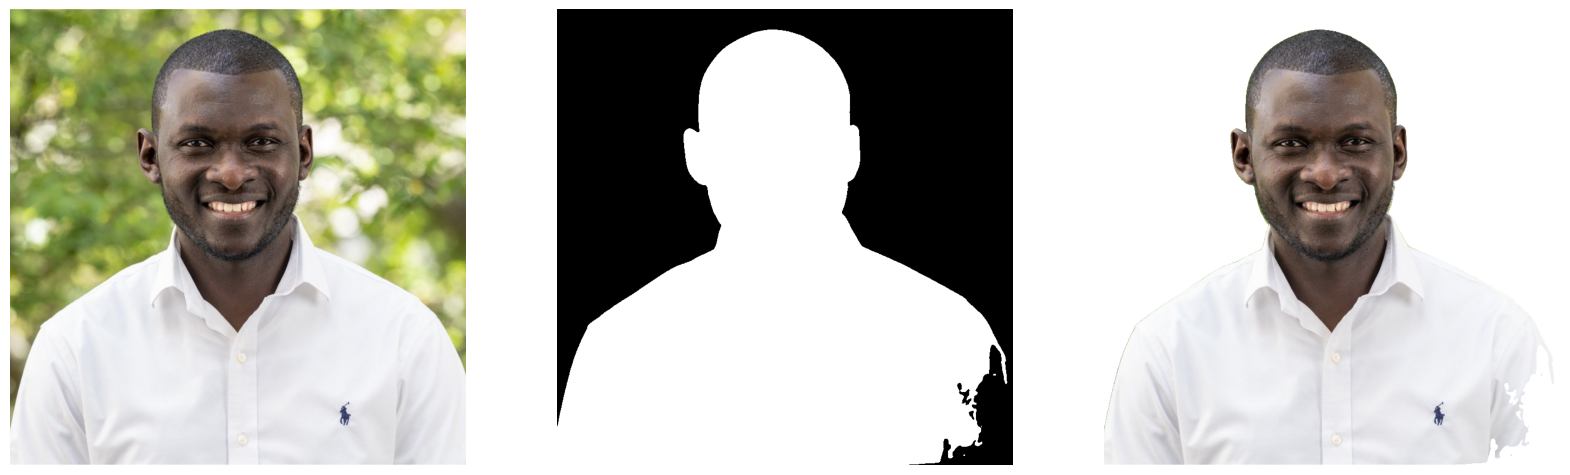

In [18]:
# Resize the network result to the image shape and round the values
# to 0 (background) and 1 (foreground).
# The network result has (1,1,512,512) shape. The `np.squeeze` function converts this to (512, 512).
resized_result = np.rint(
    cv2.resize(src=np.squeeze(result), dsize=(image.shape[1], image.shape[0]))
).astype(np.uint8)

# Create a copy of the image and set all background values to 255 (white).
bg_removed_result = image.copy()
bg_removed_result[resized_result == 0] = 255

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))
ax[0].imshow(image)
ax[1].imshow(resized_result, cmap="gray")
ax[2].imshow(bg_removed_result)
for a in ax:
    a.axis("off")

### Add a Background Image

In the segmentation result, all foreground pixels have a value of 1, all background pixels a value of 0. Replace the background image as follows:

- Load a new `background_image`.
- Resize this image to the same size as the original image.
- In `background_image`, set all the pixels where the resized segmentation result has a value of 1 - the foreground pixels in the original image - to 0.
- Add `bg_removed_result` from the previous step - the part of the original image that only contains foreground pixels - to `background_image`.

In [19]:
!ls

205-vision-background-removal.ipynb  data  model  output  README.md


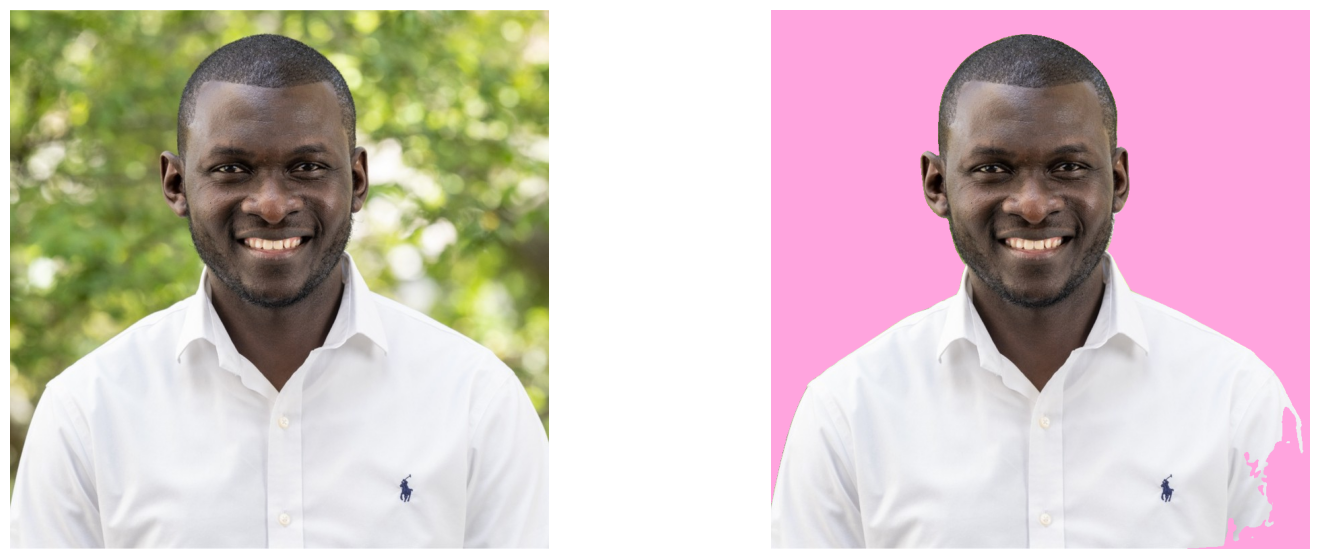

In [20]:
BACKGROUND_FILE = f"{IMAGE_DIR}/best.jpg"
OUTPUT_DIR = "output"

os.makedirs(name=OUTPUT_DIR, exist_ok=True)

background_image = cv2.cvtColor(src=cv2.imread(filename=BACKGROUND_FILE), code=cv2.COLOR_BGR2RGB)
background_image = cv2.resize(src=background_image, dsize=(image.shape[1], image.shape[0]))

# Set all the foreground pixels from the result to 0
# in the background image and add the image with the background removed.
background_image[resized_result == 1] = 0
new_image = background_image + bg_removed_result

# Save the generated image.
new_image_path = Path(f"{OUTPUT_DIR}/{IMAGE_PATH.stem}-{Path(BACKGROUND_FILE).stem}.jpg")
cv2.imwrite(filename=str(new_image_path), img=cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR))

# Display the original image and the image with the new background side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
ax[0].imshow(image)
ax[1].imshow(new_image)
for a in ax:
    a.axis("off")
plt.show()

# Create a link to download the image.
image_link = FileLink(new_image_path)
image_link.html_link_str = "<a href='%s' download>%s</a>"
display(
    HTML(
        f"The generated image <code>{new_image_path.name}</code> is saved in "
        f"the directory <code>{new_image_path.parent}</code>. You can also "
        "download the image by clicking on this link: "
        f"{image_link._repr_html_()}"
    )
)

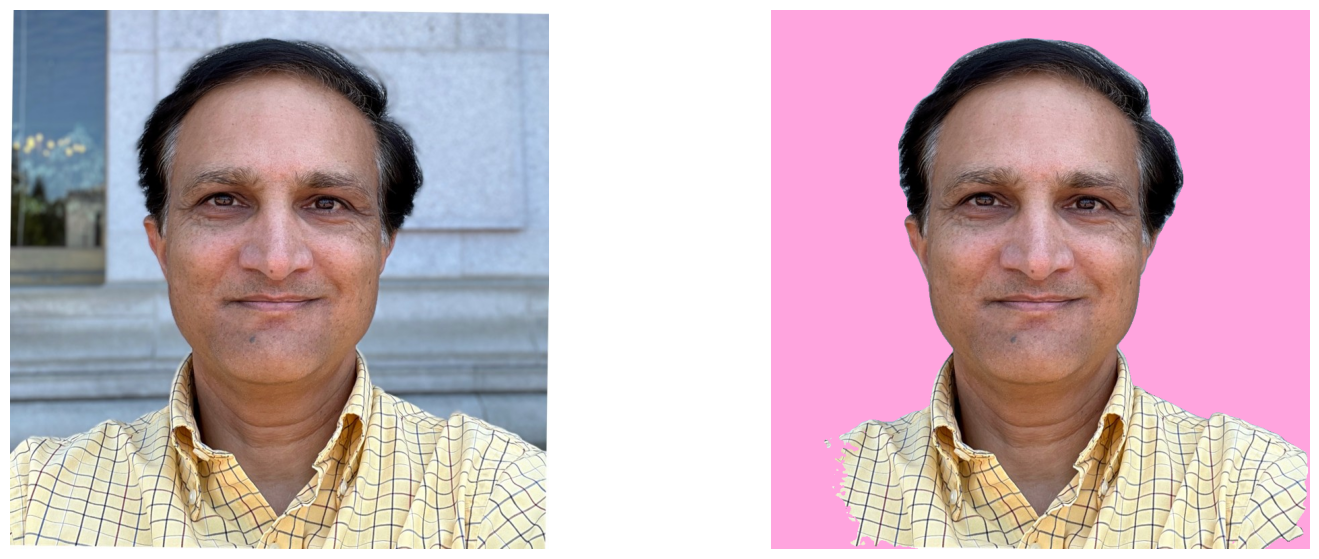

In [15]:
BACKGROUND_FILE = f"{IMAGE_DIR}/best.jpg"
OUTPUT_DIR = "output"

os.makedirs(name=OUTPUT_DIR, exist_ok=True)

background_image = cv2.cvtColor(src=cv2.imread(filename=BACKGROUND_FILE), code=cv2.COLOR_BGR2RGB)
background_image = cv2.resize(src=background_image, dsize=(image.shape[1], image.shape[0]))

# Set all the foreground pixels from the result to 0
# in the background image and add the image with the background removed.
background_image[resized_result == 1] = 0
new_image = background_image + bg_removed_result

# Save the generated image.
new_image_path = Path(f"{OUTPUT_DIR}/{IMAGE_PATH.stem}-{Path(BACKGROUND_FILE).stem}.jpg")
cv2.imwrite(filename=str(new_image_path), img=cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR))

# Display the original image and the image with the new background side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
ax[0].imshow(image)
ax[1].imshow(new_image)
for a in ax:
    a.axis("off")
plt.show()

# Create a link to download the image.
image_link = FileLink(new_image_path)
image_link.html_link_str = "<a href='%s' download>%s</a>"
display(
    HTML(
        f"The generated image <code>{new_image_path.name}</code> is saved in "
        f"the directory <code>{new_image_path.parent}</code>. You can also "
        "download the image by clicking on this link: "
        f"{image_link._repr_html_()}"
    )
)

## References

* [PIP install openvino-dev](https://github.com/openvinotoolkit/openvino/blob/releases/2021/3/docs/install_guides/pypi-openvino-dev.md)
* [OpenVINO ONNX support](https://docs.openvino.ai/2021.4/openvino_docs_IE_DG_ONNX_Support.html)
* [Model Optimizer Documentation](https://docs.openvino.ai/latest/openvino_docs_MO_DG_prepare_model_convert_model_Converting_Model_General.html)
* [U^2-Net](https://github.com/xuebinqin/U-2-Net)
* U^2-Net research paper: [U^2-Net: Going Deeper with Nested U-Structure for Salient Object Detection](https://arxiv.org/pdf/2005.09007.pdf)